<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Task1_a_validationset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [93]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [95]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np

In [96]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

fatal: destination path 'grs34806-deep-learning-project-data' already exists and is not an empty directory.


Writing a function to read the simulated data and produce lists containing the sequences and a list of 0s and 1s.

In [97]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("seq"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]

  print("Length of the datalist: ", len(datalist))
  print("Length of labellist: ", len(labellist))
  print("The number of positives in labellist: ", sum(labellist))
  #for i in range(min(5, len(datalist))):
        #print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  return datalist, labellist

In [98]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.seq",
posfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.pos")

Length of the datalist:  1000
Length of labellist:  1000
The number of positives in labellist:  507


Splitting the dataset into a training, validation and test set.

In [99]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(datalist, labellist, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, test_data, trainval_labels, test_labels = train_test_split(
      datalist, labellist, test_size=test_size,
      random_state = random_state
  )

  train_data, val_data, train_labels, val_labels = train_test_split(
      trainval_data, trainval_labels, test_size=val_size,
      random_state=random_state
  )

  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [100]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)

In [101]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 600
Training labels size: 600
Validation data size:  200
Validation labels size:  200
Test data size: 200
Test labels size: 200


Defining the provided functions

In [102]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

In [103]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array

In [104]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))

In [105]:
from d2l import torch as d2l

Function load_data including code for converting the tokenised sequence into 1-hot encoded representation so it can be fed as input to the CNN.

In [106]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num) + 1
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  #data_arrays = (seq_array, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  #print("Shape of seq_array: ", seq_array.shape)
  #print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        #seq_onehotencoding.shape)
  return data_iter

In [107]:
print("Unique labels:", torch.unique(torch.tensor(train_labels)))

Unique labels: tensor([0, 1])


In [108]:
train_iter = load_data(batch_size = 25, num_steps=100, dataset=train_data, trainlabels=train_labels)
validation_iter = load_data(batch_size=25, num_steps=100, dataset=val_data, trainlabels=val_labels)
test_iter = load_data(batch_size= 25, num_steps = 100, dataset = test_data, trainlabels = test_labels)

Building the CNN

In [109]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(),
          nn.Linear(in_features = int(128*(self.context_size//8)),
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



Trying the model with:

*   Batch size = 32
*   Context_size = 100
*   Learning_tate = 1e-3
*   Dropout_rate = 0.5
*   Num_epochs = 10

Implementing early stopping using the validation set to prevent overfitting of the model on the data.



In [110]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.7005, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6956, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6938, Validation Accuracy: 0.5000
Epoch 4: Train Loss: 0.6933, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6924, Validation Accuracy: 0.5250
Epoch 6: Train Loss: 0.6859, Validation Accuracy: 0.7400
Epoch 7: Train Loss: 0.5349, Validation Accuracy: 0.8100
Epoch 8: Train Loss: 0.3873, Validation Accuracy: 0.8150
Epoch 9: Train Loss: 0.3862, Validation Accuracy: 0.8150
Epoch 10: Train Loss: 0.3640, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8650


Epoch 1: Train Loss: 0.7003, Val Loss: 0.6935, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6952, Val Loss: 0.6932, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 3: Train Loss: 0.6931, Val Loss: 0.6930, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6941, Val Loss: 0.6927, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6917, Val Loss: 0.6924, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 6: Train Loss: 0.6904, Val Loss: 0.6895, Val Acc: 0.6400, Test Acc: 0.6150
Epoch 7: Train Loss: 0.6851, Val Loss: 0.6910, Val Acc: 0.5150, Test Acc: 0.5350
Epoch 8: Train Loss: 0.6388, Val Loss: 0.5868, Val Acc: 0.7100, Test Acc: 0.7800
Epoch 9: Train Loss: 0.4285, Val Loss: 0.4249, Val Acc: 0.8050, Test Acc: 0.8550
Epoch 10: Train Loss: 0.3910, Val Loss: 0.3914, Val Acc: 0.8200, Test Acc: 0.8650


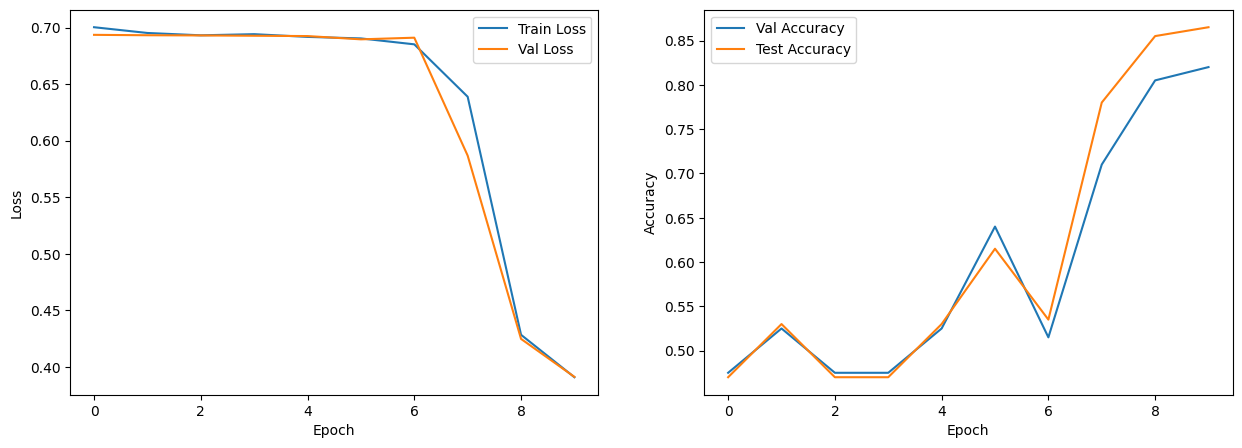

In [111]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing the same parameters as before, but with a weight decay value of 0.001

In [112]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
    weight_decay = weight_decay
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6954, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.7015, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6932, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6917, Validation Accuracy: 0.5250
Epoch 5: Train Loss: 0.6922, Validation Accuracy: 0.5250
Epoch 6: Train Loss: 0.6907, Validation Accuracy: 0.4750
Epoch 7: Train Loss: 0.6831, Validation Accuracy: 0.5400
Epoch 8: Train Loss: 0.6547, Validation Accuracy: 0.6400
Epoch 9: Train Loss: 0.4878, Validation Accuracy: 0.7050
Epoch 10: Train Loss: 0.4088, Validation Accuracy: 0.7750

Final Test Accuracy: 0.7950


Epoch 1: Train Loss: 0.7009, Val Loss: 0.6931, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6933, Val Loss: 0.6929, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 3: Train Loss: 0.6954, Val Loss: 0.6928, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 4: Train Loss: 0.6937, Val Loss: 0.6938, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6911, Val Loss: 0.6884, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 6: Train Loss: 0.6953, Val Loss: 0.6928, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 7: Train Loss: 0.6582, Val Loss: 0.6154, Val Acc: 0.7900, Test Acc: 0.8100
Epoch 8: Train Loss: 0.4847, Val Loss: 0.4485, Val Acc: 0.8100, Test Acc: 0.8500
Epoch 9: Train Loss: 0.3927, Val Loss: 0.4275, Val Acc: 0.8150, Test Acc: 0.8500
Epoch 10: Train Loss: 0.3810, Val Loss: 0.3995, Val Acc: 0.8150, Test Acc: 0.8650


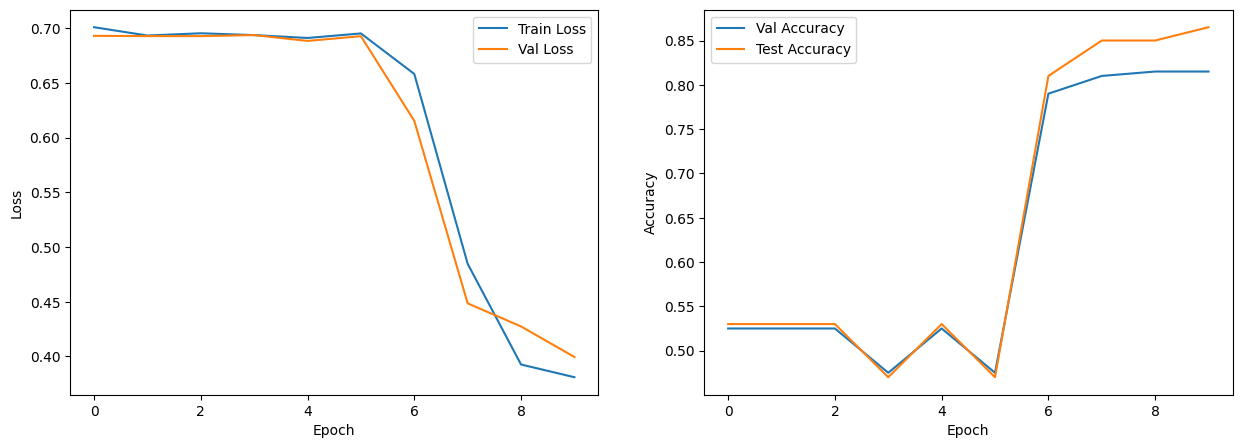

In [113]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing with a dropout rate of 0.2

In [114]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.2
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
    weight_decay = weight_decay
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6973, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6991, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6921, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6984, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6947, Validation Accuracy: 0.5200
Epoch 6: Train Loss: 0.6921, Validation Accuracy: 0.5250
Epoch 7: Train Loss: 0.6923, Validation Accuracy: 0.5500
Epoch 8: Train Loss: 0.6383, Validation Accuracy: 0.6500
Epoch 9: Train Loss: 0.4742, Validation Accuracy: 0.8150
Epoch 10: Train Loss: 0.3747, Validation Accuracy: 0.8300

Final Test Accuracy: 0.8500


Epoch 1: Train Loss: 0.7006, Val Loss: 0.6926, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6944, Val Loss: 0.6932, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6924, Val Loss: 0.6940, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6939, Val Loss: 0.6913, Val Acc: 0.5700, Test Acc: 0.6100
Epoch 6: Train Loss: 0.6912, Val Loss: 0.6861, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 7: Train Loss: 0.6340, Val Loss: 0.5957, Val Acc: 0.6650, Test Acc: 0.6600
Epoch 8: Train Loss: 0.4486, Val Loss: 0.4573, Val Acc: 0.8050, Test Acc: 0.8600
Epoch 9: Train Loss: 0.3899, Val Loss: 0.4329, Val Acc: 0.8050, Test Acc: 0.8500
Epoch 10: Train Loss: 0.3614, Val Loss: 0.4274, Val Acc: 0.8100, Test Acc: 0.8450


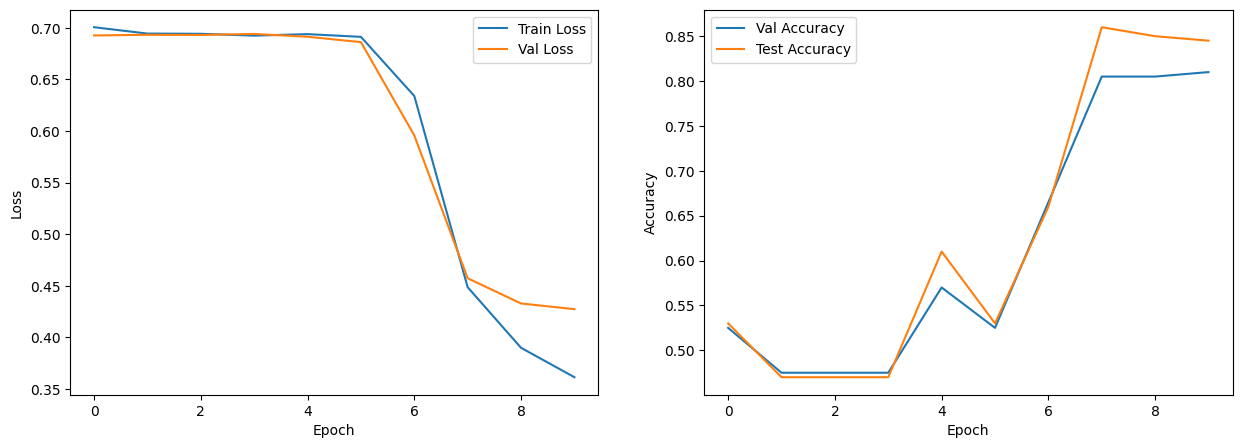

In [115]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.2
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing momentum to test performance of the model using SGD optimizer.

In [116]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
momentum = 0.5
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using SGD as the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay, momentum=momentum)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6935, Validation Accuracy: 0.5250
Epoch 2: Train Loss: 0.6933, Validation Accuracy: 0.5250
Epoch 3: Train Loss: 0.6939, Validation Accuracy: 0.5250
Epoch 4: Train Loss: 0.6925, Validation Accuracy: 0.5250
Epoch 5: Train Loss: 0.6930, Validation Accuracy: 0.5250
Epoch 6: Train Loss: 0.6938, Validation Accuracy: 0.5250
Early stopping triggered at epoch 6

Final Test Accuracy: 0.5300


Epoch 1: Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.4800, Test Acc: 0.4150
Epoch 2: Train Loss: 0.6925, Val Loss: 0.6932, Val Acc: 0.4900, Test Acc: 0.4400
Epoch 3: Train Loss: 0.6940, Val Loss: 0.6931, Val Acc: 0.5050, Test Acc: 0.4450
Epoch 4: Train Loss: 0.6942, Val Loss: 0.6932, Val Acc: 0.5100, Test Acc: 0.4550
Epoch 5: Train Loss: 0.6921, Val Loss: 0.6932, Val Acc: 0.5100, Test Acc: 0.4500
Epoch 6: Train Loss: 0.6933, Val Loss: 0.6932, Val Acc: 0.5100, Test Acc: 0.4600
Epoch 7: Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.5150, Test Acc: 0.4500
Epoch 8: Train Loss: 0.6932, Val Loss: 0.6931, Val Acc: 0.5150, Test Acc: 0.4500
Epoch 9: Train Loss: 0.6934, Val Loss: 0.6931, Val Acc: 0.5200, Test Acc: 0.4550
Epoch 10: Train Loss: 0.6927, Val Loss: 0.6932, Val Acc: 0.5200, Test Acc: 0.4550


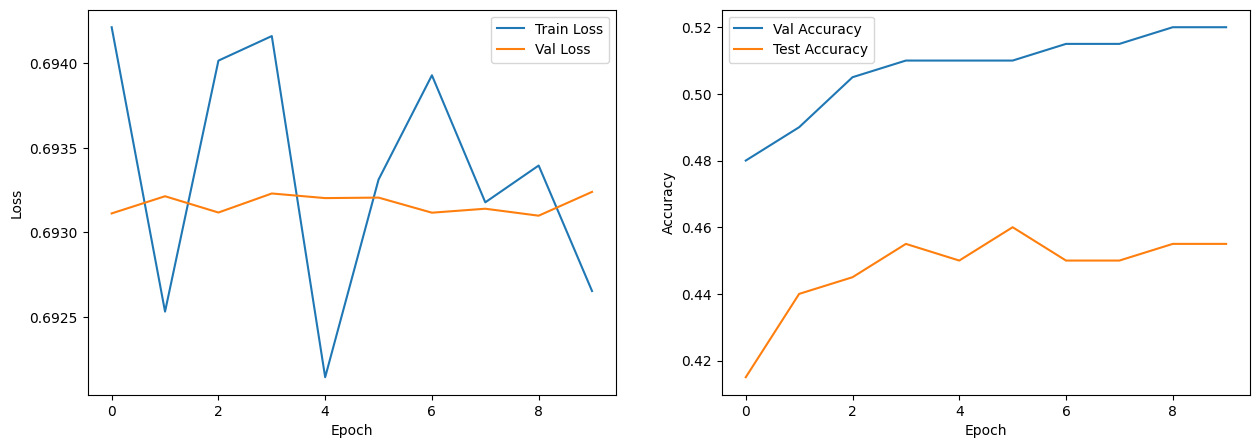

In [117]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
momentum=0.5
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay,
                            momentum=momentum)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing the batch size, going from 32 to 64, and using AdamW optimizer as performance with SGD optimizer was not optimal.

In [118]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6967, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6944, Validation Accuracy: 0.5250
Epoch 3: Train Loss: 0.6948, Validation Accuracy: 0.5100
Epoch 4: Train Loss: 0.6940, Validation Accuracy: 0.4800
Epoch 5: Train Loss: 0.6914, Validation Accuracy: 0.4750
Epoch 6: Train Loss: 0.6944, Validation Accuracy: 0.5400
Epoch 7: Train Loss: 0.6924, Validation Accuracy: 0.4750
Epoch 8: Train Loss: 0.6888, Validation Accuracy: 0.6000
Epoch 9: Train Loss: 0.6623, Validation Accuracy: 0.7200
Epoch 10: Train Loss: 0.6575, Validation Accuracy: 0.6100

Final Test Accuracy: 0.6300


Epoch 1: Train Loss: 0.7001, Val Loss: 0.6946, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6961, Val Loss: 0.6919, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 3: Train Loss: 0.6948, Val Loss: 0.6919, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 4: Train Loss: 0.6935, Val Loss: 0.6940, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6937, Val Loss: 0.6926, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 6: Train Loss: 0.6927, Val Loss: 0.6920, Val Acc: 0.6200, Test Acc: 0.6350
Epoch 7: Train Loss: 0.6901, Val Loss: 0.6903, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 8: Train Loss: 0.6776, Val Loss: 0.6804, Val Acc: 0.5500, Test Acc: 0.5500
Epoch 9: Train Loss: 0.6659, Val Loss: 0.6665, Val Acc: 0.6850, Test Acc: 0.7150
Epoch 10: Train Loss: 0.5498, Val Loss: 0.4904, Val Acc: 0.8050, Test Acc: 0.8350


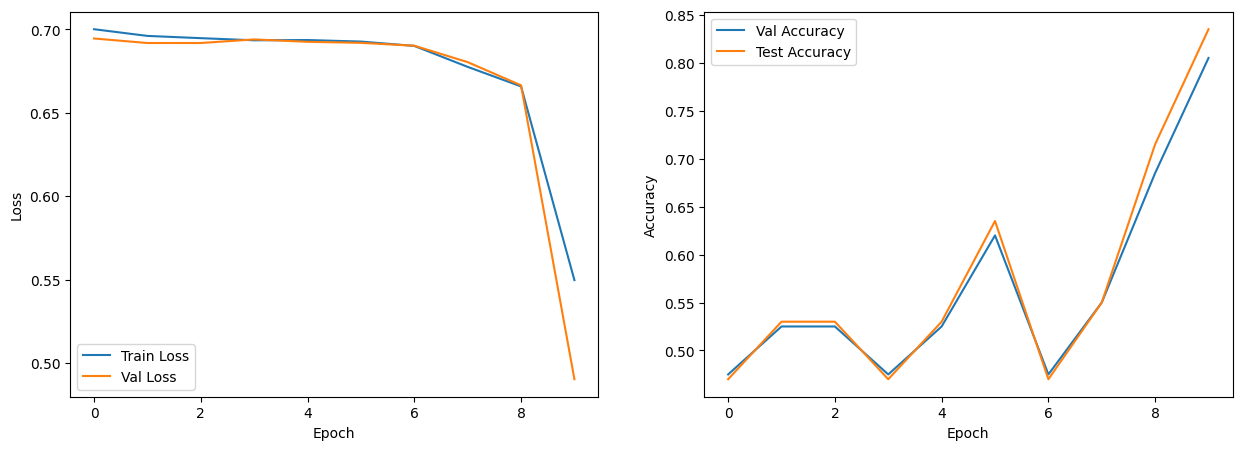

In [119]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing Batch Norm in the architecture to test performance of the model

In [120]:
class BatchNorm_ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [130]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6843, Validation Accuracy: 0.5710
Epoch 2: Train Loss: 0.6667, Validation Accuracy: 0.6020
Epoch 3: Train Loss: 0.6482, Validation Accuracy: 0.6130
Epoch 4: Train Loss: 0.6193, Validation Accuracy: 0.6310
Epoch 5: Train Loss: 0.6092, Validation Accuracy: 0.5740
Epoch 6: Train Loss: 0.5789, Validation Accuracy: 0.5900
Epoch 7: Train Loss: 0.5769, Validation Accuracy: 0.5720
Epoch 8: Train Loss: 0.5596, Validation Accuracy: 0.5600
Epoch 9: Train Loss: 0.5437, Validation Accuracy: 0.5270
Early stopping triggered at epoch 9

Final Test Accuracy: 0.6440


Epoch 1: Train Loss: 0.6894, Val Loss: 0.6923, Val Acc: 0.5050, Test Acc: 0.5510
Epoch 2: Train Loss: 0.6687, Val Loss: 0.6765, Val Acc: 0.5330, Test Acc: 0.5870
Epoch 3: Train Loss: 0.6542, Val Loss: 0.6583, Val Acc: 0.6460, Test Acc: 0.6160
Epoch 4: Train Loss: 0.6304, Val Loss: 0.6641, Val Acc: 0.5370, Test Acc: 0.5840
Epoch 5: Train Loss: 0.6211, Val Loss: 0.6761, Val Acc: 0.5120, Test Acc: 0.5670
Epoch 6: Train Loss: 0.6013, Val Loss: 0.6330, Val Acc: 0.6040, Test Acc: 0.6150
Epoch 7: Train Loss: 0.5843, Val Loss: 0.6497, Val Acc: 0.5500, Test Acc: 0.6010
Epoch 8: Train Loss: 0.5657, Val Loss: 0.6880, Val Acc: 0.5060, Test Acc: 0.5670
Epoch 9: Train Loss: 0.5592, Val Loss: 0.6520, Val Acc: 0.5760, Test Acc: 0.5870
Epoch 10: Train Loss: 0.5398, Val Loss: 0.7293, Val Acc: 0.4880, Test Acc: 0.5310


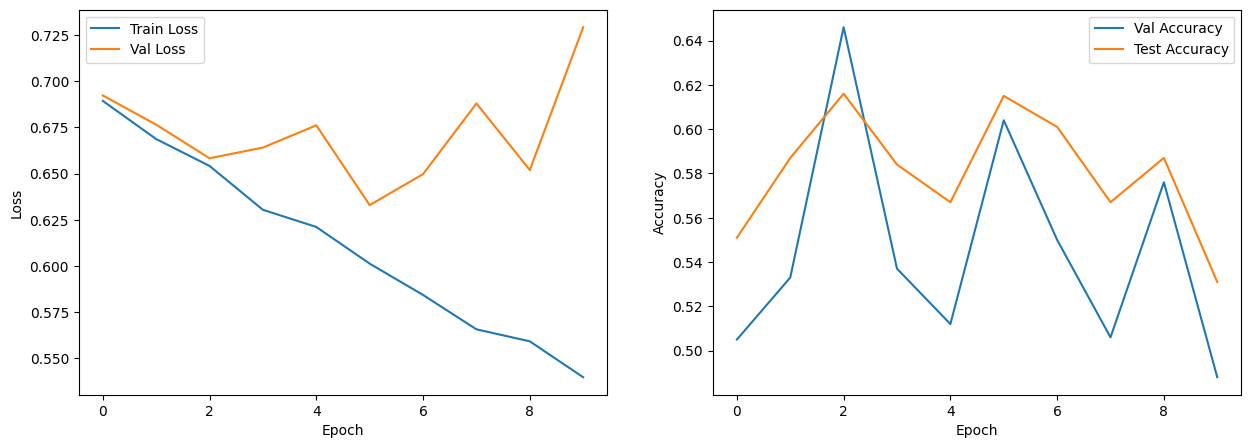

In [131]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [121]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6934, Validation Accuracy: 0.5250
Epoch 2: Train Loss: 0.6486, Validation Accuracy: 0.5950
Epoch 3: Train Loss: 0.5639, Validation Accuracy: 0.5600
Epoch 4: Train Loss: 0.4581, Validation Accuracy: 0.6750
Epoch 5: Train Loss: 0.3918, Validation Accuracy: 0.7900
Epoch 6: Train Loss: 0.3571, Validation Accuracy: 0.8100
Epoch 7: Train Loss: 0.3210, Validation Accuracy: 0.8150
Epoch 8: Train Loss: 0.2776, Validation Accuracy: 0.8100
Epoch 9: Train Loss: 0.2734, Validation Accuracy: 0.8050
Epoch 10: Train Loss: 0.2436, Validation Accuracy: 0.6950

Final Test Accuracy: 0.7500


Epoch 1: Train Loss: 0.6935, Val Loss: 0.6927, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6167, Val Loss: 0.6676, Val Acc: 0.5700, Test Acc: 0.5700
Epoch 3: Train Loss: 0.5123, Val Loss: 0.5658, Val Acc: 0.7350, Test Acc: 0.7800
Epoch 4: Train Loss: 0.4394, Val Loss: 0.4683, Val Acc: 0.7850, Test Acc: 0.8200
Epoch 5: Train Loss: 0.3815, Val Loss: 0.4772, Val Acc: 0.8050, Test Acc: 0.8450
Epoch 6: Train Loss: 0.3471, Val Loss: 0.5100, Val Acc: 0.8100, Test Acc: 0.8550
Epoch 7: Train Loss: 0.3280, Val Loss: 0.4127, Val Acc: 0.8100, Test Acc: 0.8550
Epoch 8: Train Loss: 0.2947, Val Loss: 0.4450, Val Acc: 0.8200, Test Acc: 0.8300
Epoch 9: Train Loss: 0.3206, Val Loss: 0.3925, Val Acc: 0.8050, Test Acc: 0.8600
Epoch 10: Train Loss: 0.2402, Val Loss: 0.4645, Val Acc: 0.8100, Test Acc: 0.8450


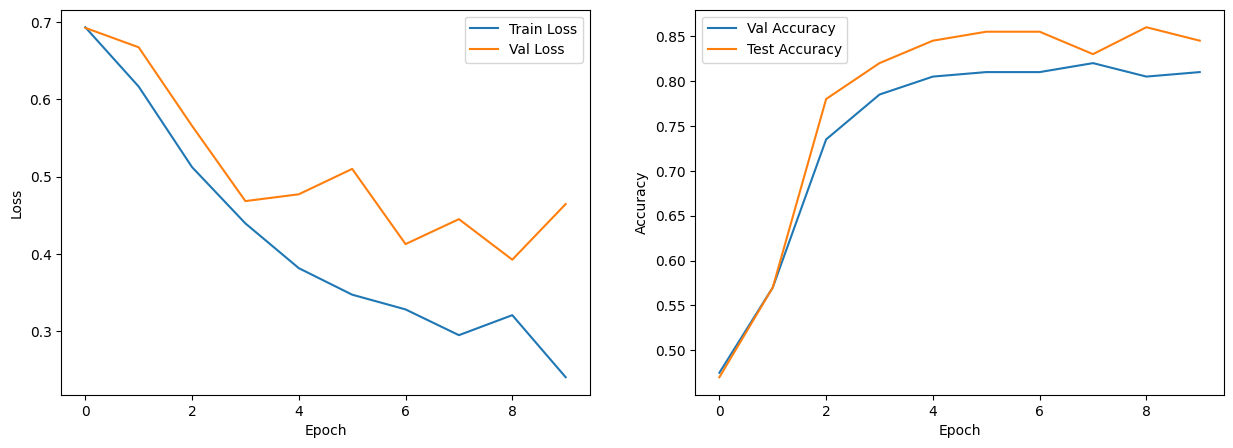

In [122]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trying the model on another simulated dataset

In [123]:
datalist2, labellist2 = read(seqfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.seq",
posfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.pos")

Length of the datalist:  5000
Length of labellist:  5000
The number of positives in labellist:  2490


In [124]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist2, labellist2
)

In [125]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 3000
Training labels size: 3000
Validation data size:  1000
Validation labels size:  1000
Test data size: 1000
Test labels size: 1000


In [126]:
train_iter_newdata = load_data(batch_size = 25, num_steps=200, dataset=train_data, trainlabels=train_labels)
validation_iter_newdata = load_data(batch_size=25, num_steps=200, dataset=val_data, trainlabels=val_labels)
test_iter_newdata = load_data(batch_size= 25, num_steps = 200, dataset = test_data, trainlabels = test_labels)

In [127]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter_newdata))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6640, Validation Accuracy: 0.6730
Epoch 2: Train Loss: 0.5955, Validation Accuracy: 0.6140
Epoch 3: Train Loss: 0.5297, Validation Accuracy: 0.7840
Epoch 4: Train Loss: 0.4819, Validation Accuracy: 0.7030
Epoch 5: Train Loss: 0.4574, Validation Accuracy: 0.5630
Epoch 6: Train Loss: 0.4510, Validation Accuracy: 0.8150
Epoch 7: Train Loss: 0.4128, Validation Accuracy: 0.7600
Epoch 8: Train Loss: 0.4043, Validation Accuracy: 0.8110
Epoch 9: Train Loss: 0.3961, Validation Accuracy: 0.7200
Epoch 10: Train Loss: 0.3933, Validation Accuracy: 0.8250

Final Test Accuracy: 0.7980


Epoch 1: Train Loss: 0.6957, Val Loss: 0.6932, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 2: Train Loss: 0.6930, Val Loss: 0.6945, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 3: Train Loss: 0.6934, Val Loss: 0.6932, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 4: Train Loss: 0.6929, Val Loss: 0.6931, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 5: Train Loss: 0.6606, Val Loss: 0.6060, Val Acc: 0.7510, Test Acc: 0.7540
Epoch 6: Train Loss: 0.5168, Val Loss: 0.4925, Val Acc: 0.8270, Test Acc: 0.8120
Epoch 7: Train Loss: 0.4424, Val Loss: 0.4522, Val Acc: 0.8440, Test Acc: 0.8180
Epoch 8: Train Loss: 0.4239, Val Loss: 0.4453, Val Acc: 0.8440, Test Acc: 0.8200
Epoch 9: Train Loss: 0.4093, Val Loss: 0.4346, Val Acc: 0.8440, Test Acc: 0.8180
Epoch 10: Train Loss: 0.4044, Val Loss: 0.4270, Val Acc: 0.8390, Test Acc: 0.8070


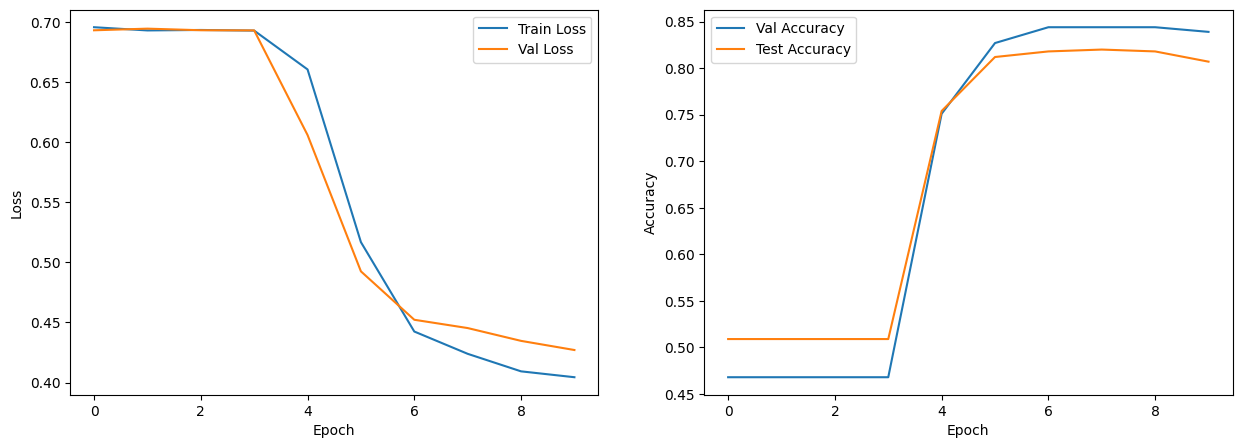

In [128]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter_newdata))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

In [ ]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 1.3237, Val Loss: 1.2788, Val Acc: 0.6880, Test Acc: 0.6810
Epoch 2: Train Loss: 1.2175, Val Loss: 1.2013, Val Acc: 0.7020, Test Acc: 0.6630
Epoch 3: Train Loss: 1.0575, Val Loss: 1.1471, Val Acc: 0.7670, Test Acc: 0.7200
Epoch 4: Train Loss: 0.9669, Val Loss: 1.0257, Val Acc: 0.8220, Test Acc: 0.8080
Epoch 5: Train Loss: 0.9354, Val Loss: 1.0416, Val Acc: 0.8100, Test Acc: 0.7890
Epoch 6: Train Loss: 0.8737, Val Loss: 0.9485, Val Acc: 0.8270, Test Acc: 0.8000
Epoch 7: Train Loss: 0.8432, Val Loss: 0.9654, Val Acc: 0.8320, Test Acc: 0.8080
Epoch 8: Train Loss: 0.8346, Val Loss: 0.9380, Val Acc: 0.8300, Test Acc: 0.7990
Epoch 9: Train Loss: 0.8047, Val Loss: 0.9367, Val Acc: 0.8350, Test Acc: 0.8030
Epoch 10: Train Loss: 0.7780, Val Loss: 0.9566, Val Acc: 0.7860, Test Acc: 0.7610


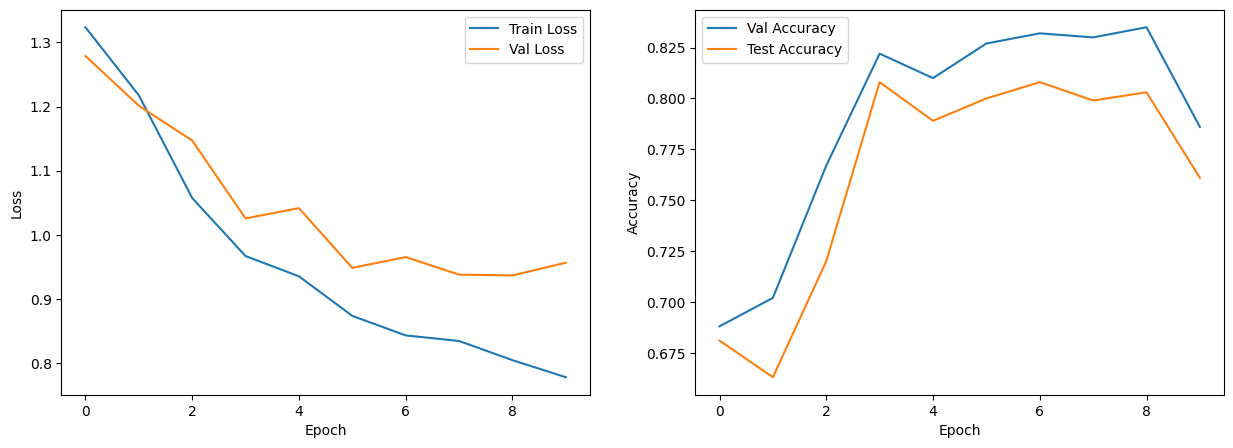

In [87]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing batch size from 32 to 64.

In [88]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6715, Validation Accuracy: 0.5790
Epoch 2: Train Loss: 0.6200, Validation Accuracy: 0.7360
Epoch 3: Train Loss: 0.5749, Validation Accuracy: 0.7660
Epoch 4: Train Loss: 0.5115, Validation Accuracy: 0.8230
Epoch 5: Train Loss: 0.4721, Validation Accuracy: 0.6860
Epoch 6: Train Loss: 0.4580, Validation Accuracy: 0.8120
Epoch 7: Train Loss: 0.4354, Validation Accuracy: 0.8270
Epoch 8: Train Loss: 0.4149, Validation Accuracy: 0.8100
Epoch 9: Train Loss: 0.3908, Validation Accuracy: 0.8270
Epoch 10: Train Loss: 0.3794, Validation Accuracy: 0.8140

Final Test Accuracy: 0.7950


Epoch 1: Train Loss: 0.6765, Val Loss: 0.6554, Val Acc: 0.6610, Test Acc: 0.6700
Epoch 2: Train Loss: 0.6139, Val Loss: 0.6110, Val Acc: 0.7060, Test Acc: 0.6820
Epoch 3: Train Loss: 0.5545, Val Loss: 0.6888, Val Acc: 0.5400, Test Acc: 0.5040
Epoch 4: Train Loss: 0.4988, Val Loss: 0.5971, Val Acc: 0.6800, Test Acc: 0.6530
Epoch 5: Train Loss: 0.4800, Val Loss: 0.5430, Val Acc: 0.7840, Test Acc: 0.7530
Epoch 6: Train Loss: 0.4503, Val Loss: 0.5175, Val Acc: 0.7960, Test Acc: 0.7770
Epoch 7: Train Loss: 0.4358, Val Loss: 0.6649, Val Acc: 0.5790, Test Acc: 0.5310
Epoch 8: Train Loss: 0.4057, Val Loss: 0.4576, Val Acc: 0.8070, Test Acc: 0.7970
Epoch 9: Train Loss: 0.3948, Val Loss: 0.4661, Val Acc: 0.8120, Test Acc: 0.7890
Epoch 10: Train Loss: 0.3869, Val Loss: 0.4916, Val Acc: 0.8070, Test Acc: 0.7890


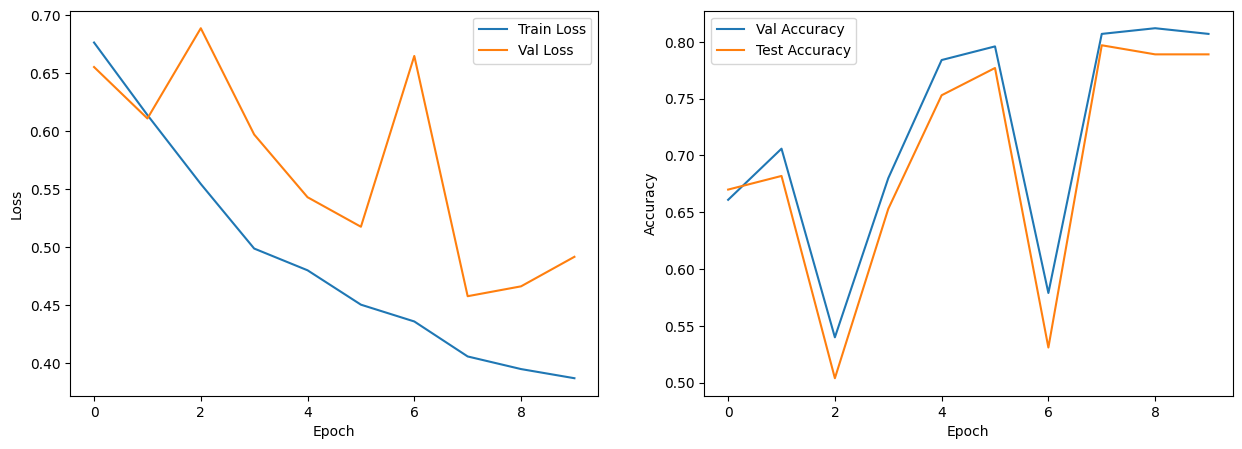

In [89]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasing the kernel size from 3 to 5 to check for better performance.

In [90]:
class BatchNorm_ProteinCNN1D_differentkernel(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=5,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [91]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6845, Validation Accuracy: 0.5160
Epoch 2: Train Loss: 0.6563, Validation Accuracy: 0.6110
Epoch 3: Train Loss: 0.6282, Validation Accuracy: 0.6230
Epoch 4: Train Loss: 0.6000, Validation Accuracy: 0.6070
Epoch 5: Train Loss: 0.5702, Validation Accuracy: 0.6390
Epoch 6: Train Loss: 0.5411, Validation Accuracy: 0.5240
Epoch 7: Train Loss: 0.5200, Validation Accuracy: 0.6260
Epoch 8: Train Loss: 0.5082, Validation Accuracy: 0.5330
Epoch 9: Train Loss: 0.4673, Validation Accuracy: 0.5760
Epoch 10: Train Loss: 0.4506, Validation Accuracy: 0.6120
Early stopping triggered at epoch 10

Final Test Accuracy: 0.6410


Epoch 1: Train Loss: 0.3450, Val Loss: 0.3370, Val Acc: 0.5960, Test Acc: 0.6340
Epoch 2: Train Loss: 0.3288, Val Loss: 0.3296, Val Acc: 0.6280, Test Acc: 0.6330
Epoch 3: Train Loss: 0.3108, Val Loss: 0.3176, Val Acc: 0.6510, Test Acc: 0.6340
Epoch 4: Train Loss: 0.3007, Val Loss: 0.3127, Val Acc: 0.6470, Test Acc: 0.6370
Epoch 5: Train Loss: 0.2818, Val Loss: 0.3259, Val Acc: 0.6400, Test Acc: 0.6000
Epoch 6: Train Loss: 0.2777, Val Loss: 0.3143, Val Acc: 0.6020, Test Acc: 0.6180
Epoch 7: Train Loss: 0.2620, Val Loss: 0.3109, Val Acc: 0.6370, Test Acc: 0.6300
Epoch 8: Train Loss: 0.2564, Val Loss: 0.3262, Val Acc: 0.6420, Test Acc: 0.6070
Epoch 9: Train Loss: 0.2417, Val Loss: 0.3259, Val Acc: 0.5550, Test Acc: 0.5920
Epoch 10: Train Loss: 0.2253, Val Loss: 0.3189, Val Acc: 0.6060, Test Acc: 0.6270


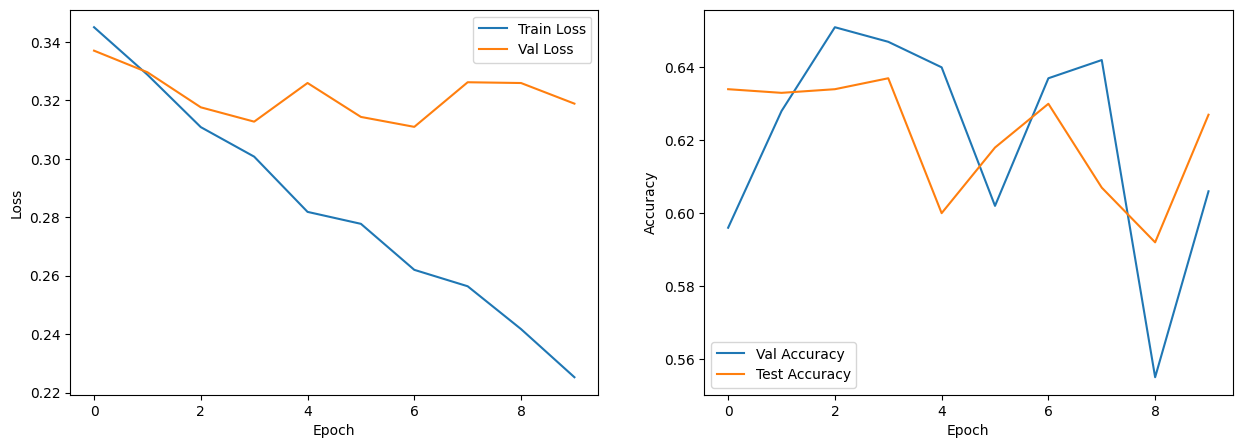

In [129]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()